# Correlation between news and stock movement

# 0. Imports

In [1]:
import os 
import sys
import pandas as pd
import yfinance as yf
import plotly as px

In [10]:
current_dir = os.getcwd()
print(current_dir)

parent_dir = os.path.dirname(current_dir)
print(parent_dir)

sys.path.insert(0,parent_dir)

c:\ML and DS Files\Kifiya AI\Kaim-week-1\notebooks
c:\ML and DS Files\Kifiya AI\Kaim-week-1


In [15]:
# Get the current working directory (notebooks folder)
notebooks_dir = os.getcwd()

# Construct the path to the scripts folder
scripts_path = os.path.join(notebooks_dir, '..', 'scripts')

# Add the scripts folder to the system path
sys.path.append(scripts_path)

In [96]:
from importlib import reload
import analysis
import data_visualization
import scripts.financial_analysis
reload(scripts.financial_analysis)
reload(analysis)
reload(data_visualization)

<module 'data_visualization' from 'c:\\ML and DS Files\\Kifiya AI\\Kaim-week-1\\notebooks\\..\\scripts\\data_visualization.py'>

In [98]:
from scripts.data_loader import DataLoader
from scripts.financial_analysis import StockAnalysis, CorrelationAnalysis, FinancialVisualizer
from analysis import  check_missing_value, headline_length_check, count_and_sort, convert_date, extract_date, perform_sentiment_analysis, nlp_keyword_topic_analysis, extract_keywords, analyze_top_publishers, classify_article_topic
from data_visualization import plot_univarate, plot_bivariate


# 1. Load data

In [24]:
# news data
file_path = r"C:\ML and DS Files\Kifiya AI\Kaim-week-1\week 1 data\Data\raw_analyst_ratings\raw_analyst_ratings.csv"
loader = DataLoader(file_path)
news_data = loader.load_data()

Data successfully loaded from C:\ML and DS Files\Kifiya AI\Kaim-week-1\week 1 data\Data\raw_analyst_ratings\raw_analyst_ratings.csv


In [ ]:
# Stock Price Data
file_path = r"C:\ML and DS Files\Kifiya AI\Kaim-week-1\week 1 data\Data\yfinance_data\AMZN_historical_data.csv"
loader = DataLoader(file_path)
stock_price_data = loader.load_data()

Data successfully loaded from C:\ML and DS Files\Kifiya AI\Kaim-week-1\week 1 data\Data\yfinance_data\AMZN_historical_data.csv


In [80]:
print(news_data.shape, stock_price_data.shape)

(1407328, 6) (6846, 9)


#### 1.1 Date aliignment (Normalizing)

In [ ]:
# Convert news data date (since it has different formatting it is complex so lets use a function)
convert_date(news_data, 'date')

In [39]:
# convert stock price data date
stock_price_data['Date'] = pd.to_datetime(stock_price_data['Date'], format='%Y-%m-%d')

In [44]:
# rename column 'Date' to 'date'
stock_price_data = stock_price_data.rename(columns={'Date': 'date'})

In [45]:
stock_price_data.head(1)

,date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,1997-05-15,0.121875,0.125,0.096354,0.097917,0.097917,1443120000,0.0,0.0


In [52]:
# Convert news_data timestamp to date-only format
news_data['date'] = pd.to_datetime(news_data['date']).dt.normalize()
news_data.head(1)

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05,A


In [48]:
stock_price_data.dtypes

date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Adj Close              float64
Volume                   int64
Dividends              float64
Stock Splits           float64
dtype: object

In [53]:
news_data.dtypes

Unnamed: 0             int64
headline              object
url                   object
publisher             object
date          datetime64[ns]
stock                 object
dtype: object

In [ ]:
'''
on='date': Ensures rows are matched based on the 'date' column.
how='inner': Ensures only matching dates are included.
Any additional columns from news_data and stock_price_data are combined into the resulting DataFrame.
'''

In [56]:
aligned_data = pd.merge(news_data, stock_price_data, on='date', how='inner')

In [82]:
aligned_data.shape

(1379682, 14)

In [63]:
aligned_data.head(2)

,Unnamed: 0,headline,url,publisher,date,stock,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05,A,122.225502,124.432503,121.856499,124.150002,124.150002,66128000,0.0,0.0
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03,A,123.400497,124.400002,123.058502,123.919998,123.919998,53420000,0.0,0.0


# 2. Sentiment Analysis

In [ ]:
data_with_sentiment = perform_sentiment_analysis(aligned_data, text_column='headline')

In [59]:
print(data_with_sentiment[['headline', 'compound', 'sentiment_label']].head(10))

                                            headline  compound sentiment_label
0            Stocks That Hit 52-Week Highs On Friday     0.000         neutral
1         Stocks That Hit 52-Week Highs On Wednesday     0.000         neutral
2                      71 Biggest Movers From Friday     0.000         neutral
3       46 Stocks Moving In Friday's Mid-Day Session     0.000         neutral
4  B of A Securities Maintains Neutral on Agilent...     0.296        positive
5  CFRA Maintains Hold on Agilent Technologies, L...    -0.128        negative
6  UBS Maintains Neutral on Agilent Technologies,...     0.000         neutral
7  Agilent Technologies shares are trading higher...     0.296        positive
8  Wells Fargo Maintains Overweight on Agilent Te...    -0.128        negative
9         10 Biggest Price Target Changes For Friday     0.000         neutral


In [64]:
data_with_sentiment.columns

Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock', 'Open',
       'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
       'Stock Splits', 'neg', 'neu', 'pos', 'compound', 'sentiment_label'],
      dtype='object')

###### 2.1 Plots on sentimental data

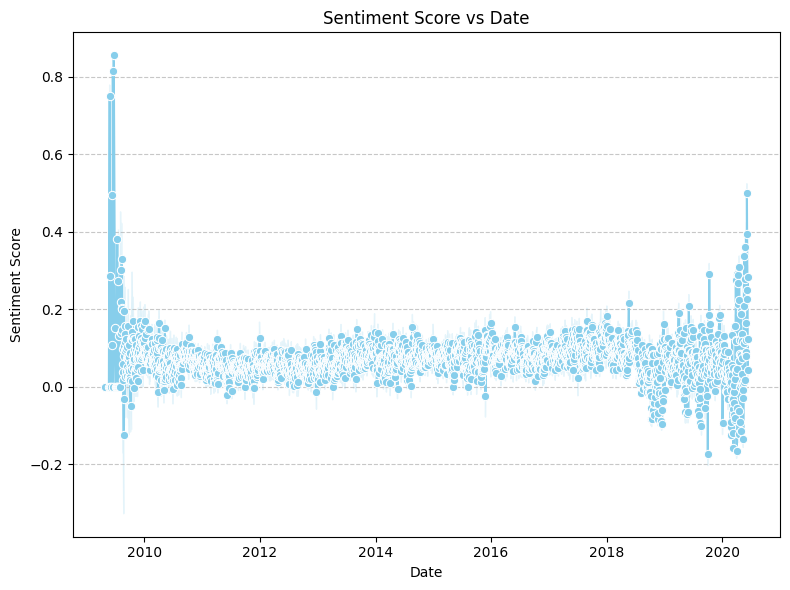

In [106]:
plot_bivariate(data = data_with_sentiment, x_column='date', y_column = 'compound', plot_type='line', title='Sentiment Score vs Date',  x_axis_t='Date', y_axis_t='Sentiment Score' )

# 3. Analysis

#### 3.1 Stock Analysis

In [ ]:
# Instantiate and process stock returns
stock_analysis = StockAnalysis(data_with_sentiment)
data_with_returns = stock_analysis.calculate_daily_returns()

In [69]:
data_with_sentiment.head(2) # daily return column added

,Unnamed: 0,headline,url,publisher,date,stock,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,neg,neu,pos,compound,sentiment_label,Daily Return
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05,A,122.225502,124.432503,121.856499,124.150002,124.150002,66128000,0.0,0.0,0.0,1.0,0.0,0.0,neutral,NaN
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03,A,123.400497,124.400002,123.058502,123.919998,123.919998,53420000,0.0,0.0,0.0,1.0,0.0,0.0,neutral,-0.185262


#### 3.2 Correlation Analysis

In [79]:
correlation_analysis = CorrelationAnalysis(data_with_returns)
correlation_coefficient = correlation_analysis.calculate_correlation()

# Output results
print(data_with_returns)
print(f"Correlation Coefficient: {correlation_coefficient}")

         Unnamed: 0                                           headline  \
0                 0            Stocks That Hit 52-Week Highs On Friday   
1                 1         Stocks That Hit 52-Week Highs On Wednesday   
2                 2                      71 Biggest Movers From Friday   
3                 3       46 Stocks Moving In Friday's Mid-Day Session   
4                 4  B of A Securities Maintains Neutral on Agilent...   
...             ...                                                ...   
1379677     1413844             Top Narrow Based Indexes For August 29   
1379678     1413845  Recap: Wednesday's Top Percentage Gainers and ...   
1379679     1413846  UPDATE: Oppenheimer Color on China Zenix Auto ...   
1379680     1413847  Oppenheimer Initiates China Zenix At Outperfor...   
1379681     1413848  China Zenix Auto International Opens For Tradi...   

                                                       url          publisher  \
0        https://www.benzinga.